# **Importar librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# **Cargar datos**

In [ ]:
train = pd.read_csv('train_kaggle.csv')
test = pd.read_csv('test_kaggle.csv')
sample_submission = pd.read_csv('submission.csv')



# **Análisis exploratorio básico**

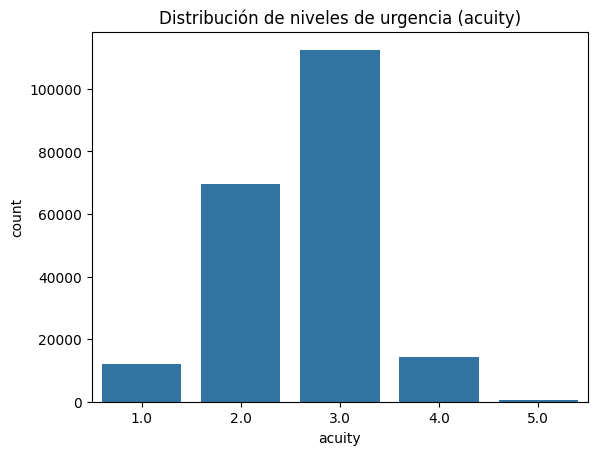

In [ ]:
sns.countplot(x='acuity', data=train)
plt.title('Distribución de niveles de urgencia (acuity)')
plt.show()

# **Estadísticos básicos y chequeo valores nulos**

In [ ]:
def conteoVal(df):
  for col in df.columns:
    print(col)
    print(df[col].value_counts())

conteoVal(train)

stay_id
stay_id
37012144    1
32563223    1
39010345    1
34685893    1
35539621    1
           ..
34513482    1
33733026    1
38166174    1
39813242    1
33064255    1
Name: count, Length: 209050, dtype: int64
intime
intime
2149-12-09 13:16:00    3
2170-07-18 11:06:00    3
2136-03-02 19:28:00    2
2129-03-21 12:45:00    2
2170-05-24 12:25:00    2
                      ..
2116-08-27 02:09:00    1
2179-07-25 22:38:00    1
2178-04-17 05:49:00    1
2149-12-02 04:32:00    1
2168-06-28 19:28:00    1
Name: count, Length: 208494, dtype: int64
outtime
outtime
2122-11-22 16:05:00    2
2128-01-20 16:50:00    2
2135-09-17 06:15:00    2
2133-05-29 20:50:00    2
2165-02-17 15:18:00    2
                      ..
2125-05-07 12:03:00    1
2133-06-11 11:46:00    1
2128-04-06 00:02:00    1
2180-12-02 00:36:00    1
2147-11-19 08:47:00    1
Name: count, Length: 208584, dtype: int64
gender
gender
F    113740
M     95310
Name: count, dtype: int64
race
race
WHITE                                        11232

In [ ]:
def getMediasFijas(df):
  mediasFijas = {}

  columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()

  print(columnas_categoricas)

  for col in columnas_categoricas:
    mediasFijas[col] = df[col].mode()[0]

  for col in df.columns:
    if col not in columnas_categoricas:
      mediasFijas[col] = df[col].median()

  return mediasFijas


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re # Import the regular expression module

def pipeline(df_input, mediasFijas=None, is_train=True, tfidf_obj=None):
    df = df_input.copy()

    ranges = {
    'temperature': (80.0, 110.0), # Asumiendo Fahrenheit predominante
    'heartrate':   (30.0, 220.0), # Desde bradicardia extrema a taquicardia máxima
    'resprate':    (8.0, 60.0),   # 1796.5 es claramente un error de entrada
    'o2sat':       (50.0, 100.0), # No puede existir saturación > 100%
    'sbp':         (50.0, 250.0), # Límites típicos de presión sistólica
    'dbp':         (30.0, 150.0)  # Límites típicos de presión diastólica
    }

    # Aplicamos el clip de forma masiva
    for col, (bajo, alto) in ranges.items():
        if col in df.columns:
            df[col] = df[col].clip(lower=bajo, upper=alto)

    mapping_disposition = {
    'LEFT WITHOUT BEING SEEN': 0, # Mínima intervención
    'ELOPED': 0,                  # Se fue sin aviso
    'LEFT AGAINST MEDICAL ADVICE': 1, # Se fue contra consejo médico
    'HOME': 2,                    # Alta estándar
    'OTHER': 2,                   # Otros (generalmente no críticos)
    'TRANSFER': 3,                # Necesita cuidados en otro centro
    'ADMITTED': 4,                # Ingreso hospitalario (Grave)
    'EXPIRED': 5                  # Fallecimiento (Máxima gravedad)
    }

    df['disposition'] = df['disposition'].map(mapping_disposition)

    # Convertimos intime y outtime con format='mixed' para manejar segundos ausentes
    df['intime'] = pd.to_datetime(df['intime'], format='mixed', errors='coerce')
    df['outtime'] = pd.to_datetime(df['outtime'], format='mixed', errors='coerce')

    # 1. Aseguramos que sea numérico y limitamos el rango de 0 a 10
    df['pain'] = pd.to_numeric(df['pain'], errors='coerce')
    df['pain'] = df['pain'].clip(lower=0, upper=10)

    # 2. Definimos los límites (bins) y las etiquetas (labels)
    # Los bins funcionan así: (-0.1 a 5], (5 a 8], (8 a 10]
    bins_pain = [-0.1, 5, 8, 10]
    labels_pain = [0, 1, 2] # 0: sin dolor, 1: con dolor, 2: extremo

    # 3. Creamos la nueva columna mapeada
    # Usamos .astype(float) primero si hay NaNs, o .astype(int) si prefieres números enteros
    df['pain_category'] = pd.cut(df['pain'], bins=bins_pain, labels=labels_pain).astype(float)

    df['no_pain'] = df['pain_category'].apply(lambda x: 1 if x == 0 else 0)

    df.drop(columns=['pain_category'], errors='ignore', inplace=True)

    df['heartrate_med_proxy'] = df['heartrate'] * df['medrecon_count']

    # Hipoxia Severa: < 90% | Hipoxia Leve: 90-94% | OK: 95-100%
    bins_o2 = [80, 89, 94, 100]
    labels_o2 = [-2, -1, 0]
    df['o2sat_status'] = pd.cut(df['o2sat'], bins=bins_o2, labels=labels_o2)

    # 1. Calculamos la diferencia numérica
    df['pulse_pressure'] = df['sbp'] - df['dbp']

    # 2. Categorizamos según rangos clínicos típicos:
    # Bajo (Narrow): < 25 mmHg (puede indicar fallo cardíaco o shock)
    # Normal: 30 - 60 mmHg
    # Alto (Wide): > 60 mmHg (indica rigidez arterial o problemas en válvulas)
    bins_pp = [0, 24, 60, 150]
    labels_pp = [-1, 0, 1]

    df['pulse_pressure'] = pd.cut(df['pulse_pressure'], bins=bins_pp, labels=labels_pp)

    #Si algo varia

    df['is_unstable'] = (
      (df['o2sat_status'] != 0) |
      (df['heartrate'] > 100) |
      (df['pulse_pressure'] != 0) |
      (df['resprate'] > 20)
    ).astype(int)

    # Mapeamos los valores string a valores numéricos
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})

    # 1. Definimos el diccionario con las prioridades que pediste
    mapping_transport = {
        'WALK IN': 0,
        'AMBULANCE': 1,
        'HELICOPTER': 2
    }

    # 2. Aplicamos el mapeo.
    # Los valores que no están en el diccionario (UNKNOWN y OTHER) se volverán NaN.
    # 3. Usamos .fillna(-1) para que "el resto" sea -1.
    df['arrival_transport'] = df['arrival_transport'].map(mapping_transport).fillna(-1).astype(int)

    # TF-IDF
    if is_train:
        tfidf_obj = TfidfVectorizer(max_features=10, stop_words='english')
        tfidf_matrix = tfidf_obj.fit_transform(df['chiefcomplaint'].fillna('none'))
    else:
        tfidf_matrix = tfidf_obj.transform(df['chiefcomplaint'].fillna('none'))

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_obj.get_feature_names_out(), index=df.index)

    # 2. Identificamos columnas que ya existen en el df original
    columnas_duplicadas = [col for col in tfidf_df.columns if col in df.columns]

    # 3. Borramos del tfidf_df esas columnas para que no "pisen" nada
    tfidf_df = tfidf_df.drop(columns=columnas_duplicadas)

    df = pd.concat([df, tfidf_df], axis=1)

    # Nivel 1 (Emergencia extrema)
    emergencias = ['trauma', 'gunshot', 'stroke']

    patronEmer = '|'.join(emergencias)

    # Cuenta cuántas veces aparecen las palabras del patrón en el texto
    df['is_emergency'] = (df['chiefcomplaint'].str.lower().str.count(patronEmer).fillna(0) != 0)

    #Detectar si es algo periodico leve nivel 5
    checkeos= ['refill','check','removal','eval']
    patronCheckeo = '|'.join(checkeos)
    df['is_periodic_check'] = (df['chiefcomplaint'].str.lower().str.contains(patronCheckeo).fillna(0) != 0)

    df['no_meds'] = df['pyxis_count'] == 0

    # Corrected the boolean operation with parentheses
    df['has_anestesics'] = (df['no_meds'] == 0) & (df['no_pain'] == 1)

    # Sanitize column names for LightGBM
    def sanitize_col_names(df_to_sanitize):
        cols = df_to_sanitize.columns
        new_cols = []
        for col in cols:
            new_col = re.sub(r'[^A-Za-z0-9_]+', '', str(col)) # Remove non-alphanumeric/underscore
            new_cols.append(new_col)
        df_to_sanitize.columns = new_cols
        return df_to_sanitize

    df = sanitize_col_names(df)

    # Definimos pesos por síntoma
    pesos = {
        'chest': 3,   # Muy grave
        'breath': 3,  # Muy grave
        'dyspnea': 3, # Muy grave
        'suicidal': 2,# Grave
        'abdominal': 1, # Moderado
        'fever': 1     # Moderado
    }

    def calcular_gravedad(texto):
        texto = str(texto).lower()
        score = 0
        for palabra, valor in pesos.items():
            if palabra in texto:
                score += valor
        return score

    # Creamos una única columna numérica
    df['chiefcomplaint'] = df['chiefcomplaint'].apply(calcular_gravedad)

    df['shock_index'] = df['heartrate'] / df['sbp']

    df.drop(columns=['intime', 'outtime', 'race'], errors='ignore', inplace=True)

    if is_train:
      mediasFijas = getMediasFijas(df)

    df = df.fillna(mediasFijas)

    # Esto mantiene solo la primera aparición de cada nombre de columna
    df = df.loc[:, ~df.columns.duplicated()]

    return df, tfidf_obj, mediasFijas

# **Entrenando al modelo**

### **Codificar género**

In [ ]:
trainPipe, tfidf_obj, mediasFijas = pipeline(train)

['o2sat_status', 'pulse_pressure']


In [ ]:
# Convert categorical columns to integers for XGBoost compatibility
categorical_cols_to_convert = [
  'temperature_status', 'heartrate_status', 'resprate_status', 'o2sat_status',
  'pulse_pressure', 'med_complexity_status', 'treatment_intensity_status',
  'monitoring_status'
]

for col in categorical_cols_to_convert:
    if col in trainPipe.columns:
      trainPipe[col] = trainPipe[col].astype(int)

# 'X' contiene los datos clínicos (quitamos el ID y el objetivo)
X = trainPipe.drop(columns=['acuity', 'stay_id'], errors='ignore')

# 'y' es lo que queremos predecir
# Adjust acuity to be 0-indexed for XGBoost compatibility
y = trainPipe['acuity'] - 1

print(trainPipe.columns.shape)

(35,)


In [ ]:
# Usamos stratify=y para que ambos grupos tengan la misma proporción de urgencias
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

lgbm = LGBMClassifier(
    n_estimators=256,
    learning_rate=0.1,
    class_weight='balanced'
    )

# 2. Entrenamos LightGBM (él ya usa su propio class_weight='balanced')
print("Entrenando LightGBM...")
lgbm.fit(X_train, y_train)
scores = cross_val_score(lgbm, X, y, cv=5, scoring='f1_macro')

Entrenando LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 167240, number of used features: 33
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1790
[LightGBM] [Info] Number of data points in the train set: 167240, number of used features: 33

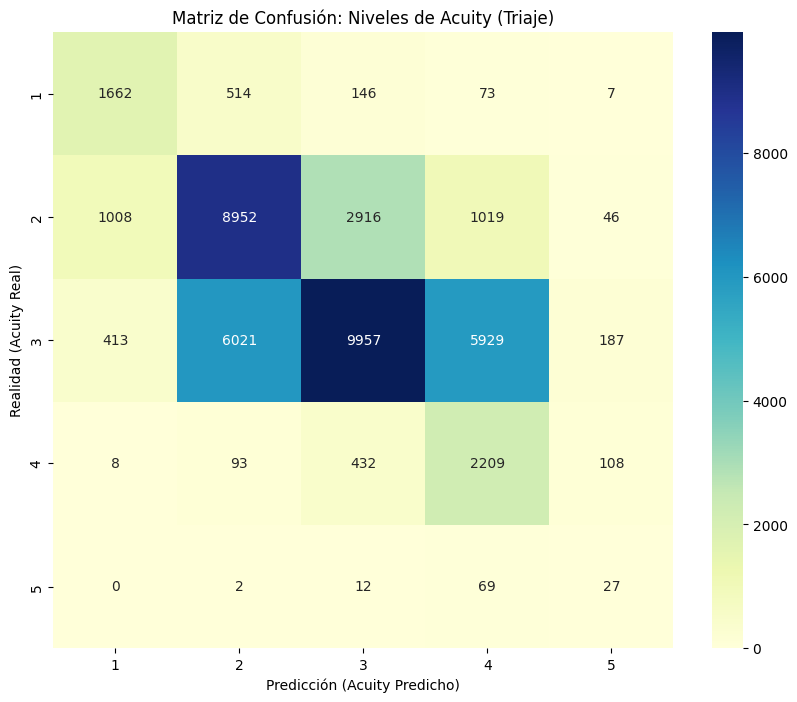

              precision    recall  f1-score   support

         0.0       0.54      0.69      0.61      2402
         1.0       0.57      0.64      0.61     13941
         2.0       0.74      0.44      0.55     22507
         3.0       0.24      0.78      0.36      2850
         4.0       0.07      0.25      0.11       110

    accuracy                           0.55     41810
   macro avg       0.43      0.56      0.45     41810
weighted avg       0.64      0.55      0.56     41810



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Obtener predicciones de validación (no de test, para poder comparar)
# Asumiendo que guardaste un set de validación X_val, y_val
y_val_pred = lgbm.predict(X_val)

# 2. Crear la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# 3. Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de Confusión: Niveles de Acuity (Triaje)')
plt.ylabel('Realidad (Acuity Real)')
plt.xlabel('Predicción (Acuity Predicho)')
plt.show()

# 4. Mostrar métricas por cada nivel
print(classification_report(y_val, y_val_pred))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
'''
# 1. Seleccionar columnas numéricas (excluyendo IDs)
cols_clinicas = ['is_periodic_check','no_pain']

# 2. Calcular el promedio por nivel
df_profile = trainPipe.groupby('acuity')[cols_clinicas].mean()

# 3. Estandarizar para que sean comparables
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_profile),
                         columns=df_profile.columns,
                         index=df_profile.index)

# 4. Graficar Heatmap0
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.T, annot=True, cmap='RdBu_r', center=0)
plt.title('¿Qué define a cada nivel de Acuity?')
plt.show()'''

"\n# 1. Seleccionar columnas numéricas (excluyendo IDs)\ncols_clinicas = ['is_periodic_check','no_pain']\n\n# 2. Calcular el promedio por nivel\ndf_profile = trainPipe.groupby('acuity')[cols_clinicas].mean()\n\n# 3. Estandarizar para que sean comparables\nscaler = StandardScaler()\ndf_scaled = pd.DataFrame(scaler.fit_transform(df_profile),\n                         columns=df_profile.columns,\n                         index=df_profile.index)\n\n# 4. Graficar Heatmap0\nplt.figure(figsize=(12, 8))\nsns.heatmap(df_scaled.T, annot=True, cmap='RdBu_r', center=0)\nplt.title('¿Qué define a cada nivel de Acuity?')\nplt.show()"

In [ ]:
# 1. Extraer importancias y crear un DataFrame
importancias = pd.DataFrame({
    'columna': X_train.columns,
    'importancia': lgbm.feature_importances_
}).sort_values(by='importancia', ascending=False)

# 2. Ver las 10 mejores (las que más ayudan)
print("--- TOP 10 VARIABLES ---")
print(importancias.head(25))

# 3. Ver las candidatas a ser borradas (las que menos ayudan)
print("\n--- VARIABLES MENOS IMPORTANTES ---")
ceros = importancias[importancias['importancia'] == 0]
print(importancias.tail(25))

print(importancias[importancias['columna']=='is_periodic_check'])

# 4. Contar cuántas tienen importancia CERO
print(f"\nHay {len(ceros)} columnas con importancia 0 (Inútiles).")

--- TOP 10 VARIABLES ---
                columna  importancia
32          shock_index         3927
8                   dbp         3823
7                   sbp         3740
3           temperature         3591
4             heartrate         3533
15  heartrate_med_proxy         2852
13      vitalsign_count         2106
9                  pain         1911
12          pyxis_count         1875
5              resprate         1875
6                 o2sat         1480
11       medrecon_count         1216
2           disposition         1057
1     arrival_transport          886
29    is_periodic_check          550
10       chiefcomplaint          458
0                gender          448
27             transfer          375
23                 fall          354
19                  abd          324
25             headache          285
26                  leg          257
14              no_pain          252
17       pulse_pressure          236
18          is_unstable          184

--- VARIABLE

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# --- CAMBIO 1: Función ajustada para una sola clase ---
def get_mean_abs_shap_single_class(shap_values_for_class, feature_names):
    # shap_values_for_class es un array 2D (muestras, variables)
    mean_shap = np.abs(shap_values_for_class).mean(axis=0)
    return pd.Series(mean_shap, index=feature_names)

# (Asumimos que y_val y y_val_pred ya existen)
indices_aciertos = np.where(y_val == y_val_pred)[0]
indices_errores = np.where(y_val != y_val_pred)[0]

# 3. Calculamos SHAP
explainer = shap.TreeExplainer(lgbm)

# Calculamos SHAP para aciertos y errores (usamos .iloc para seguridad)
shap_aciertos_all = explainer.shap_values(X_val.iloc[indices_aciertos])
shap_errores_all = explainer.shap_values(X_val.iloc[indices_errores])

# --- CAMBIO 2: Extraer solo la clase 4 (Acuity 5) ---
# Nota: Si tu modelo empieza en 0, Acuity 5 es el índice 4.
# Si diera error, prueba con el índice 5.
class_idx = 4

# Obtenemos los valores SHAP específicos para Acuity 5
shap_aciertos_a5 = shap_aciertos_all[class_idx]
shap_errores_a5 = shap_errores_all[class_idx]

# 2. Calculamos las importancias medias solo para esta clase
imp_aciertos_a5 = get_mean_abs_shap_single_class(shap_aciertos_a5, X_val.columns)
imp_errores_a5 = get_mean_abs_shap_single_class(shap_errores_a5, X_val.columns)

# 3. DataFrame comparativo
df_comp = pd.DataFrame({
    'Importancia Aciertos (A5)': imp_aciertos_a5,
    'Importancia Errores (A5)': imp_errores_a5
})

df_comp['Dif_Errores_Aciertos'] = df_comp['Importancia Errores (A5)'] - df_comp['Importancia Aciertos (A5)']

# 4. Plot de las variables que más confunden al modelo en Acuity 5
top_dif = df_comp.sort_values(by='Dif_Errores_Aciertos', ascending=False).head(15)

plt.figure(figsize=(10, 8))
top_dif['Dif_Errores_Aciertos'].plot(kind='barh', color='salmon')
plt.title('Variables que inducen a ERROR en ACUITY 5\n(Tienen más peso cuando el modelo falla)')
plt.xlabel('Exceso de peso en Errores vs Aciertos (Mean |SHAP|)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

ValueError: Length of values (5) does not match length of index (33)

In [ ]:
# 1. Procesar los datos de test con tu pipeline
# Nota: 'tfidf_obj' es el objeto que devolvió el pipeline al procesar el train
X_test_final, _, _= pipeline(test, is_train=False, tfidf_obj=tfidf_obj, mediasFijas=mediasFijas)

print(trainPipe.columns.shape)

# Convert categorical columns to integers for consistency with training data
categorical_cols_to_convert = [
    'temperature_status', 'heartrate_status', 'resprate_status', 'o2sat_status',
    'pulse_pressure', 'med_complexity_status', 'treatment_intensity_status',
    'monitoring_status'
]

for col in categorical_cols_to_convert:
    if col in X_test_final.columns:
        X_test_final[col] = X_test_final[col].astype(int)

# 2. Asegurar que las columnas coinciden con el entrenamiento
X_test_final = X_test_final[X.columns.drop('acuity', errors='ignore')]

# 3. Realizar la predicción con tu mejor modelo
predicciones = lgbm.predict(X_test_final)

# 4. Crear el DataFrame de entrega
submission = pd.DataFrame({
    'stay_id': test['stay_id'],
    'acuity': predicciones.astype(int) # Kaggle requiere que sean enteros
})

submission['acuity'] = submission['acuity'] + 1 # Vuelve a 1-indexar

# 5. Guardar el archivo
submission.to_csv('submission_final.csv', index=False)